In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil


from glob import glob
from tqdm import tqdm

import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

**Mounted Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -r dataset
!unzip /content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/images/eaed09039206.jpg  
  inflating: dataset/train/images/eaed1e245167.jpg  
  inflating: dataset/train/images/eaedb251e670.jpg  
  inflating: dataset/train/images/eaeead418936.jpg  
  inflating: dataset/train/images/eaeeb1c2ecdd.jpg  
  inflating: dataset/train/images/eaef70ba842d.jpg  
  inflating: dataset/train/images/eaf036991cb3.jpg  
  inflating: dataset/train/images/eaf06e9e07db.jpg  
  inflating: dataset/train/images/eaf20f7d8945.jpg  
  inflating: dataset/train/images/eaf3a9a87868.jpg  
  inflating: dataset/train/images/eaf3d05d20a6.jpg  
  inflating: dataset/train/images/eaf3d24fb032.jpg  
  inflating: dataset/train/images/eaf3f734b5ce.jpg  
  inflating: dataset/train/images/eaf467f871a2.jpg  
  inflating: dataset/train/images/eaf65b4e3c45.jpg  
  inflating: dataset/train/images/eaf7f876411a.jpg  
  inflating: dataset/train/images/eafa35356cf8.jpg  
  inflating: dataset/train/images/eafa65caf8e7.j

In [4]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15836, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15836 (delta 0), reused 3 (delta 0), pack-reused 15831
Receiving objects: 100% (15836/15836), 14.49 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (10869/10869), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.5/592.5 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.6 MB/s eta 0:00:00


**Import library**

In [5]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

**HelperFunction**

In [6]:
def extract_plot_bb(data,image = "None"):
    w = data["plot-bb"]["width"]
    h = data["plot-bb"]["height"]
    x0 = data["plot-bb"]["x0"] + w/2
    y0 = data["plot-bb"]["y0"] + h/2
    image_w,image_h,c = image.shape
    x0 = x0/image_h
    y0 = y0/image_w
    w = w/image_h
    h = h/image_w

    return [x0, y0, w, h, "plot-bb"]

def extract_label_bbox(data, rows, img_id,image = "None",x_tick=None,y_tick=None):
    common = []
    if data["chart-type"] != 'line':
      return None
    common+= [img_id, data["source"], data["chart-type"]]
    # TRAIN_FOLDER = "/content/dataset/train/images/"
    # image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
    image_w,image_h,c = image.shape
    # print(image_w,image_h)
    for box in data["text"]:
        # x0 = box["polygon"]["x0"]
        # y0 = box["polygon"]["y1"]
        # w = abs(box["polygon"]["x1"] - box["polygon"]["x0"]) + abs(box["polygon"]["x2"] - box["polygon"]["x1"])
        # h = abs(box["polygon"]["y3"] - box["polygon"]["y1"])
        # x0 = box["polygon"]["x0"]
        # y0 = box["polygon"]["y0"]
        # w = box["polygon"]["x1"] - box["polygon"]["x0"]
        # h = box["polygon"]["y3"] - box["polygon"]["y0"]
        # print(box["polygon"]["x2"],box["polygon"]["x0"],box["polygon"]["y2"],box["polygon"]["y0"])
        x0 = (box["polygon"]["x0"] + box["polygon"]["x2"])/2
        y0 = (box["polygon"]["y0"] + box["polygon"]["y2"])/2
        w = box["polygon"]["x2"] - box["polygon"]["x0"]
        h = box["polygon"]["y3"] - box["polygon"]["y0"]
        x0 = x0/image_h
        y0 = y0/image_w
        w = w/image_h
        h = h/image_w

        label = box["role"]
        if label == 'tick_label':
          if y_tick is None:
            y_tick = 150
          #heuristic
          if box["polygon"]["x2"] < y_tick:
              label = 'y_' + label
          elif box["polygon"]["y0"] > x_tick:
              label = 'x_' + label
          else:
              if box["polygon"]["x0"] < y_tick:
                label = 'y_' + label
              elif box["polygon"]["y2"] > x_tick:
                label = 'x_' + label
        if label == 'x_tick_label':
          continue
        box_row = common + [x0, y0, w, h, label]
        rows.append(box_row)
    rows.append(common + extract_plot_bb(data,image)) 
    return rows
        
def extract_tick_bbox(data, rows, img_id,image = "None"):
    common = []
    if data["chart-type"] != 'line':
      return None,None,None
    common+= [img_id , data["source"], data["chart-type"]]
    # TRAIN_FOLDER = "/content/dataset/train/images/"
    # image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
    image_w,image_h,c = image.shape
    x_tick = 0
    y_tick = 0
    len_x = 0
    len_y = 0
    for axis in data["axes"].keys():
        for box in data["axes"][axis]["ticks"]:
            w = 5
            h = 5
            x0 = box["tick_pt"]["x"]
            y0 = box["tick_pt"]["y"]
            if axis == 'x-axis':
              # print("here")
              x_tick += y0
              len_x += 1
            else:
              y_tick += x0
              len_y += 1
            x0 = x0/image_h
            y0 = y0/image_w
            w = w/image_h
            h = h/image_w

            label = axis + "-tick"
            box_row = common + [x0, y0, w, h,label]
            rows.append(box_row)
    x_tick = x_tick / len_x
    if len_y != 0:
      y_tick = y_tick / len_y
    else: y_tick = None
    # print(img_id)
    # print(x_tick,y_tick)
    for axis in data["visual-elements"]["lines"]:
        for box in axis:
            w = 10
            h = 10
            x0 = box["x"]
            y0 = box["y"]

            x0 = x0/image_h
            y0 = y0/image_w
            w = w/image_h
            h = h/image_w

            label = "visual-point"
            box_row = common + [x0, y0, w, h,label]
            rows.append(box_row)

    return rows,x_tick,y_tick

In [7]:
ANNOTATION = "/content/dataset/train/annotations/*.json"
TRAIN_FOLDER = "/content/dataset/train/images/"
rows = []
for file_name in tqdm(glob(ANNOTATION)):
    label_bbox = []
    tick_bbox = []
    with open(file_name) as f:
        data = json.load(f)
        img_id = file_name.split("/")[-1].split(".")[0]
        image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
        tick_bbox,x_tick,y_tick = extract_tick_bbox(data, tick_bbox, img_id,image)
        if tick_bbox == None:
           continue
        # print("================")
        label_bbox = extract_label_bbox(data, label_bbox, img_id,image,x_tick,y_tick)
        # print(label_bbox)
        # print(tick_bbox)
        data_rows = label_bbox + tick_bbox
    rows += data_rows
    # break

100%|██████████| 60578/60578 [02:22<00:00, 426.16it/s]


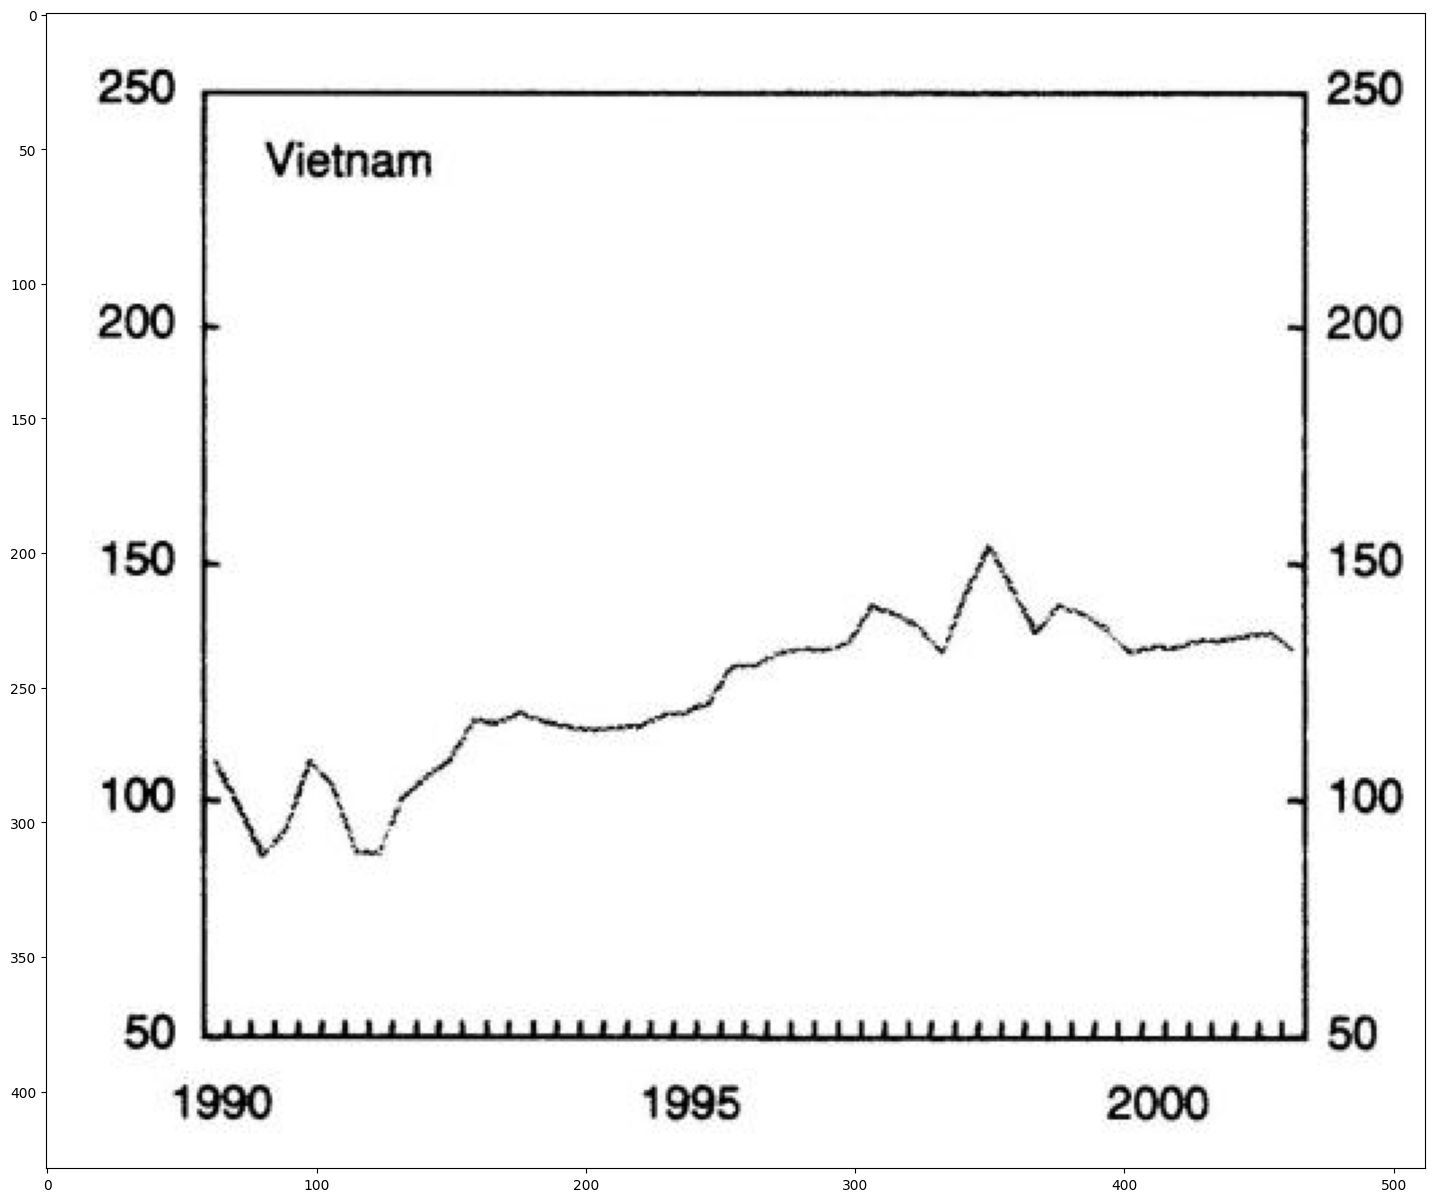

In [8]:
image_file = "dataset/train/images/{}.jpg".format('0db1f0461622')
image = Image.open(image_file)
plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(image)
plt.show()

In [9]:
df = pd.DataFrame(rows)
df.columns = ["image_id", "source", "chart", "x0", "y0", "w", "h", "label"]
df.head() 

,image_id,source,chart,x0,y0,w,h,label
0,1af857126bf7,generated,line,0.539530,0.075812,0.792735,0.101083,chart_title
1,1af857126bf7,generated,line,0.039530,0.382671,0.023504,0.245487,axis_title
2,1af857126bf7,generated,line,0.519231,0.965704,0.106838,0.039711,axis_title
3,1af857126bf7,generated,line,0.135684,0.604693,0.019231,0.039711,y_tick_label
4,1af857126bf7,generated,line,0.103632,0.530686,0.083333,0.043321,y_tick_label


In [10]:
df[(df["label"] == 7) & (df["source"] == "generated")]

,image_id,source,chart,x0,y0,w,h,label


**Convert label**

In [11]:
def get_stoi(df):
    """Get String to Index dictionary"""
    stoi = {}
    for idx, string in enumerate(df.label.unique()):
        stoi[string] = idx
    itos = {item[1]: item[0] for item in stoi.items()}
    df = df.replace({"label": stoi})
    return stoi

stoi = get_stoi(df)
print(stoi)
NUM_CLASSES =  len(stoi)
df = df[df["label"].isin(list(stoi.keys()))]
df = df.replace({"label": stoi})

{'chart_title': 0, 'axis_title': 1, 'y_tick_label': 2, 'plot-bb': 3, 'x-axis-tick': 4, 'y-axis-tick': 5, 'visual-point': 6, 'tick_label': 7, 'other': 8, 'tick_grouping': 9, 'legend_label': 10}


In [12]:
def get_new_annotation(df):
    for tup in df.groupby("image_id"):
        name = tup[0]
        x = []
        y = []
        w = []
        h = []
        label = []
        for ele in tup:
          try:
            x = ele['x0'].to_list()
            y = ele['y0'].to_list()
            w = ele['w'].to_list()
            h = ele['h'].to_list()
            label = ele['label'].to_list()
          except:
            continue
        with open('new_annotation/{}.txt'.format(name),'a') as f:
            for i in range(len(x)):
                f.write("{} {} {} {} {}\n".format(label[i],x[i],y[i],w[i],h[i]))

In [13]:
!rm -r new_annotation
!mkdir new_annotation
get_new_annotation(df)

rm: cannot remove 'new_annotation': No such file or directory


In [14]:
annotations = [os.path.join('new_annotation', x) for x in os.listdir('new_annotation') if x[-3:] == "txt"]

**Test Image**

[['0', '0.48616600790513836', '0.10839160839160839', '0.7470355731225297', '0.13286713286713286'], ['2', '0.08201581027667984', '0.229020979020979', '0.041501976284584984', '0.038461538461538464'], ['2', '0.08201581027667984', '0.2762237762237762', '0.041501976284584984', '0.04195804195804196'], ['2', '0.08201581027667984', '0.32342657342657344', '0.041501976284584984', '0.038461538461538464'], ['2', '0.08201581027667984', '0.3688811188811189', '0.041501976284584984', '0.038461538461538464'], ['2', '0.08102766798418973', '0.4178321678321678', '0.039525691699604744', '0.038461538461538464'], ['2', '0.08102766798418973', '0.4632867132867133', '0.039525691699604744', '0.038461538461538464'], ['2', '0.08201581027667984', '0.5122377622377622', '0.041501976284584984', '0.038461538461538464'], ['2', '0.08794466403162056', '0.5611888111888111', '0.029644268774703556', '0.038461538461538464'], ['2', '0.08794466403162056', '0.6066433566433567', '0.029644268774703556', '0.038461538461538464'], ['

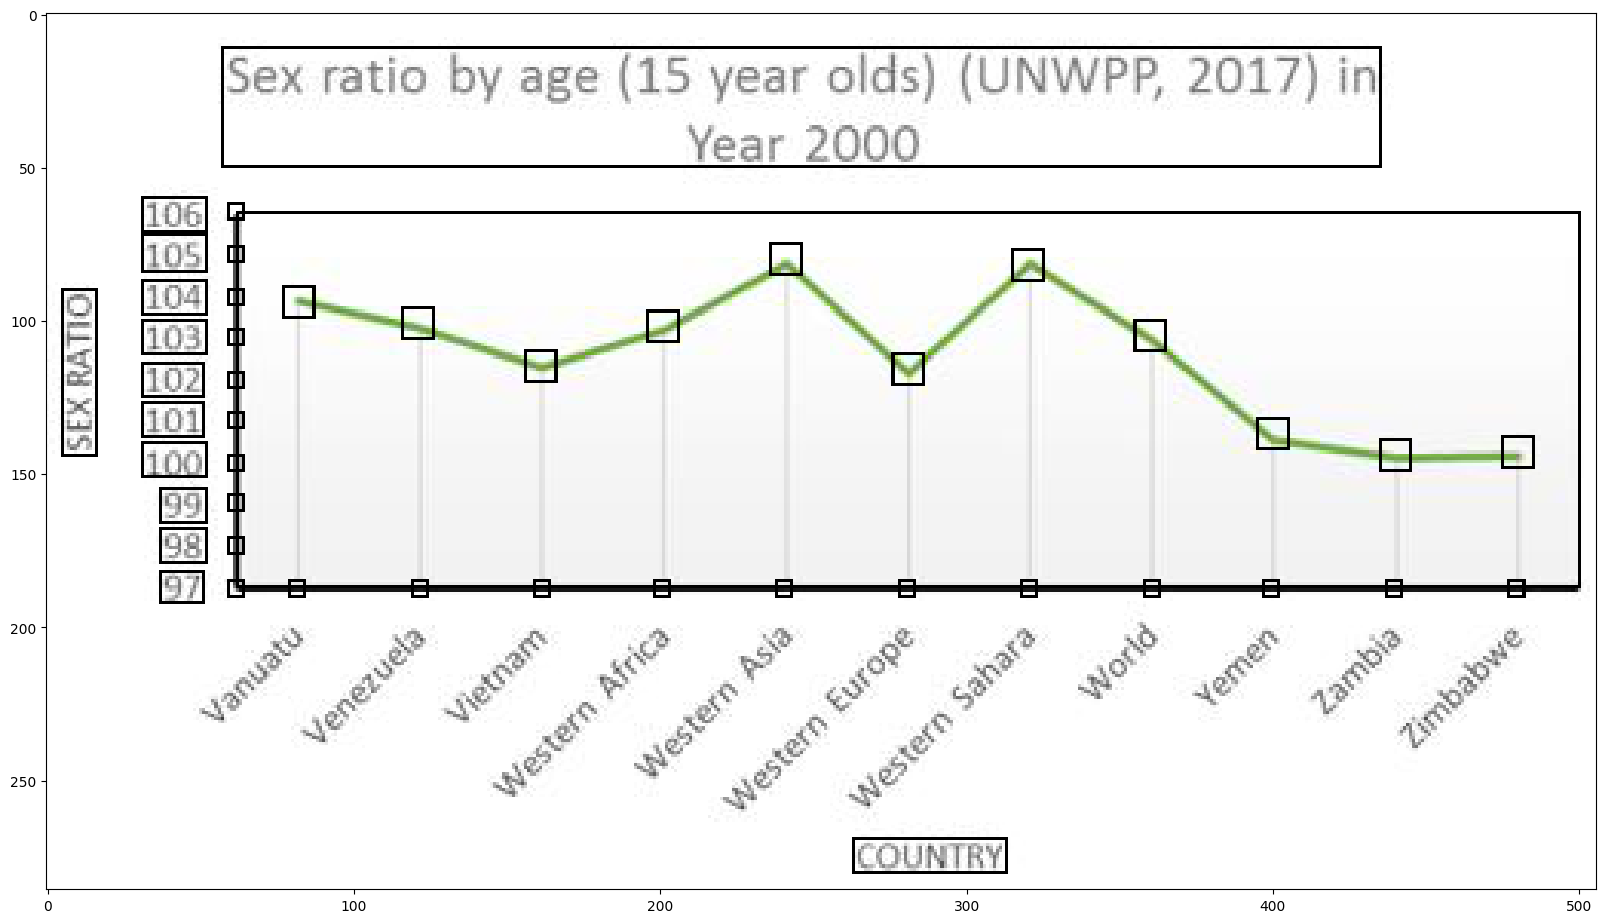

In [15]:
# annotations = '/content/new_annotation/*'
import matplotlib.patches as patches
class_id_to_name_mapping = {v : k for k,v in stoi.items()}
# print(itos)
# fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (20,15)
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    print(w,h)
    # print(image.size)
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    # print(transformed_annotations)
    # print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        if class_id_to_name_mapping[obj_cls] == 'tick_label':
          plotted_image.rectangle(((x0,y0), (x1,y1)),outline = "yellow")
        else: plotted_image.rectangle(((x0,y0), (x1,y1)),outline = "black")
  
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
# annotation_file = 'new_annotation/27139b4912ea.txt'
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    print(annotation_list)
    annotation_list = [[float(y) for y in x] for x in annotation_list]

# print(annotation_list)
#Get the corresponding image file
# print(annotation_file)
image_file = annotation_file.replace("new_annotation", "dataset/train/images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [16]:
images = [os.path.join('dataset/train/images', x.replace("txt","jpg")) for x in os.listdir('new_annotation') if x[-3:] == "txt" and x != "5ffa8c60b34c.txt"]
annotations = [os.path.join('new_annotation', x) for x in os.listdir('new_annotation') if x[-3:] == "txt" and x != "5ffa8c60b34c.txt"]
images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [17]:
!rm -r chart2table
!mkdir chart2table
!mkdir chart2table/images
!mkdir chart2table/labels
!mkdir chart2table/images/train chart2table/images/val chart2table/images/test chart2table/labels/train chart2table/labels/val chart2table/labels/test

rm: cannot remove 'chart2table': No such file or directory


In [18]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'chart2table/images/train')
move_files_to_folder(val_images, 'chart2table/images/val/')
move_files_to_folder(test_images, 'chart2table/images/test/')
move_files_to_folder(train_annotations, 'chart2table/labels/train/')
move_files_to_folder(val_annotations, 'chart2table/labels/val/')
move_files_to_folder(test_annotations, 'chart2table/labels/test/')

**Training**

In [19]:
!rm -f /content/yolov5/data/chart.yaml
with open("/content/yolov5/data/chart.yaml","a") as f:
    f.write("train: /content/chart2table/images/train\n")
    f.write("val: /content/chart2table/images/val\n")
    f.write("test: /content/chart2table/images/test\n")
    f.write("nc: 11\n")
    f.write("names: ['chart_title', 'axis_title', 'y_tick_label', 'plot-bb', 'x-axis-tick', 'y-axis-tick', 'visual-point', 'tick_label', 'other', 'tick_grouping', 'legend_label']")

In [20]:
# !python yolov5/train.py --img 640 --cfg yolov5/models/yolov5s.yaml --hyp /content/yolov5/data/hyps/hyp.scratch-high.yaml --batch 32 --epochs 100 --data yolov5/data/chart.yaml --weights best.pt --workers 24 --name train_chart_det
#--weights /content/drive/MyDrive/miniProject/pretrain/best_5m_line.pt
!python yolov5/train.py --img 640 --cfg yolov5/models/yolov5m.yaml --hyp /content/yolov5/data/hyps/hyp.no-augmentation.yaml --batch 32 --epochs 100 --data yolov5/data/chart.yaml --weights /content/drive/MyDrive/miniProject/pretrain/best_5m_line_new.pt --workers 24 --name train_chart_det

train: weights=/content/drive/MyDrive/miniProject/pretrain/best_5m_line_new.pt, cfg=yolov5/models/yolov5m.yaml, data=yolov5/data/chart.yaml, hyp=/content/yolov5/data/hyps/hyp.no-augmentation.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=train_chart_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-174-g5eb7f7d Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0

In [21]:
!cp "/content/yolov5/runs/train/train_chart_det/weights/best.pt" "/content/drive/MyDrive/miniProject/pretrain"

In [22]:
!python yolov5/detect.py --source /content/chart2table/images/test --weights /content/yolov5/runs/train/train_chart_det/weights/best.pt --conf 0.25 --name yolo_test_det --save-txt

detect: weights=['/content/yolov5/runs/train/train_chart_det/weights/best.pt'], source=/content/chart2table/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_test_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-174-g5eb7f7d Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20893344 parameters, 0 gradients, 48.0 GFLOPs
image 1/2495 /content/chart2table/images/test/0003a50817cf.jpg: 480x640 1 chart_title, 2 axis_titles, 9 y_tick_labels, 1 plot-bb, 11 x-axis-ticks, 8 y-axis-ticks, 10 visual-points, 66.1ms
image 2/2495 /content/chart2table/images/test/000614d3eab6.jpg: 448x640 1 chart_title, 2 ax

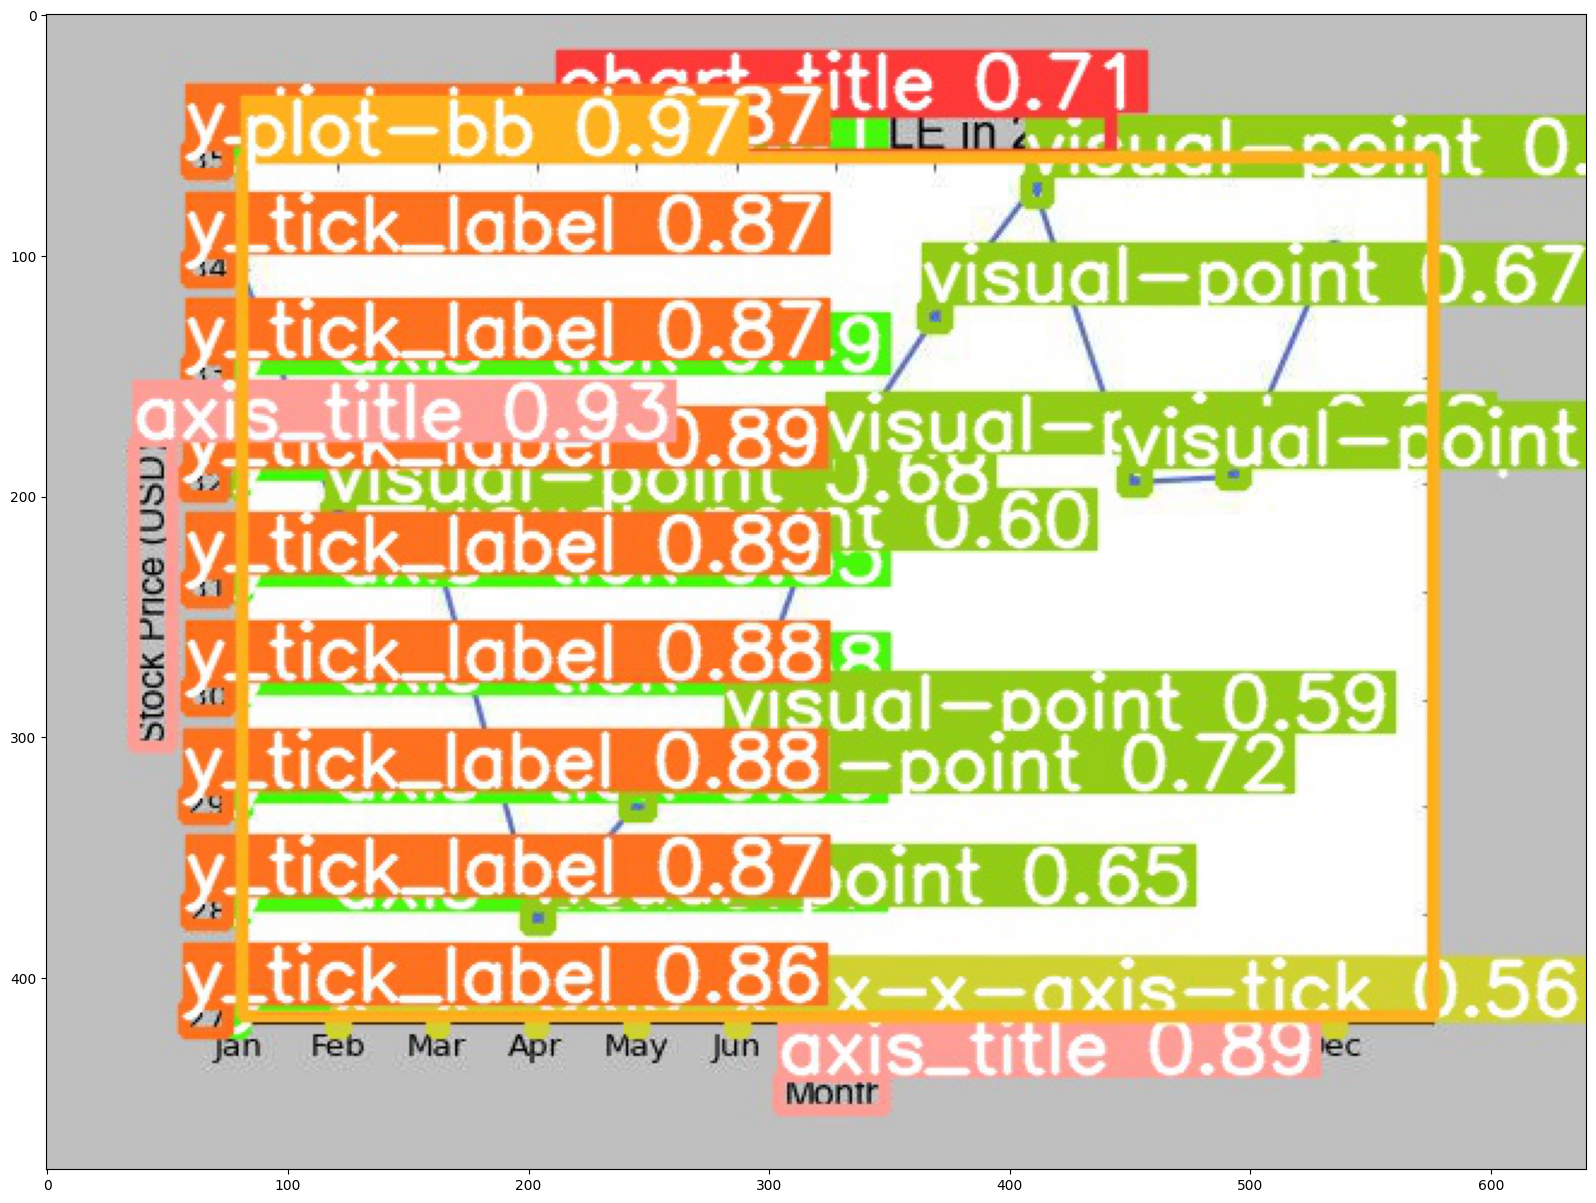

In [23]:
plt.rcParams["figure.figsize"] = (20,15)
detections_dir = "/content/yolov5/runs/detect/yolo_test_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [24]:
!python yolov5/val.py --weights /content/yolov5/runs/train/train_chart_det/weights/best.pt --data yolov5/data/chart.yaml --task test --name yolo_det

val: data=yolov5/data/chart.yaml, weights=['/content/yolov5/runs/train/train_chart_det/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-174-g5eb7f7d Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20893344 parameters, 0 gradients, 48.0 GFLOPs
test: Scanning /content/chart2table/labels/test... 2495 images, 0 backgrounds, 5 corrupt: 100% 2495/2495 [00:03<00:00, 812.89it/s]
test: WARNING ⚠️ /content/chart2table/images/test/7fd62e14bdc1.jpg: ignoring corrupt image/label: negative label values [  -0.062098]
test: WARNING ⚠️ /content/chart2table/images/test/9766b9331e71.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1

[['4', '0.145875', '0.827778', '0.0100604', '0.0185185'], ['6', '0.43662', '0.212963', '0.0201207', '0.0407407'], ['4', '0.962777', '0.827778', '0.0100604', '0.0185185'], ['4', '0.262575', '0.827778', '0.0100604', '0.0185185'], ['4', '0.78672', '0.827778', '0.0120724', '0.0185185'], ['4', '0.612676', '0.827778', '0.0100604', '0.0185185'], ['4', '0.437626', '0.827778', '0.0100604', '0.0185185'], ['4', '0.320926', '0.827778', '0.0100604', '0.0185185'], ['6', '0.61167', '0.592593', '0.0201207', '0.037037'], ['4', '0.671026', '0.827778', '0.0100604', '0.0185185'], ['4', '0.846076', '0.827778', '0.0100604', '0.0185185'], ['5', '0.115694', '0.82963', '0.0100604', '0.0222222'], ['4', '0.495976', '0.827778', '0.0100604', '0.0185185'], ['4', '0.205231', '0.827778', '0.0120724', '0.0185185'], ['5', '0.115694', '0.157407', '0.0100604', '0.0185185'], ['6', '0.78672', '0.474074', '0.0201207', '0.037037'], ['4', '0.379276', '0.827778', '0.0100604', '0.0185185'], ['4', '0.904427', '0.827778', '0.0100

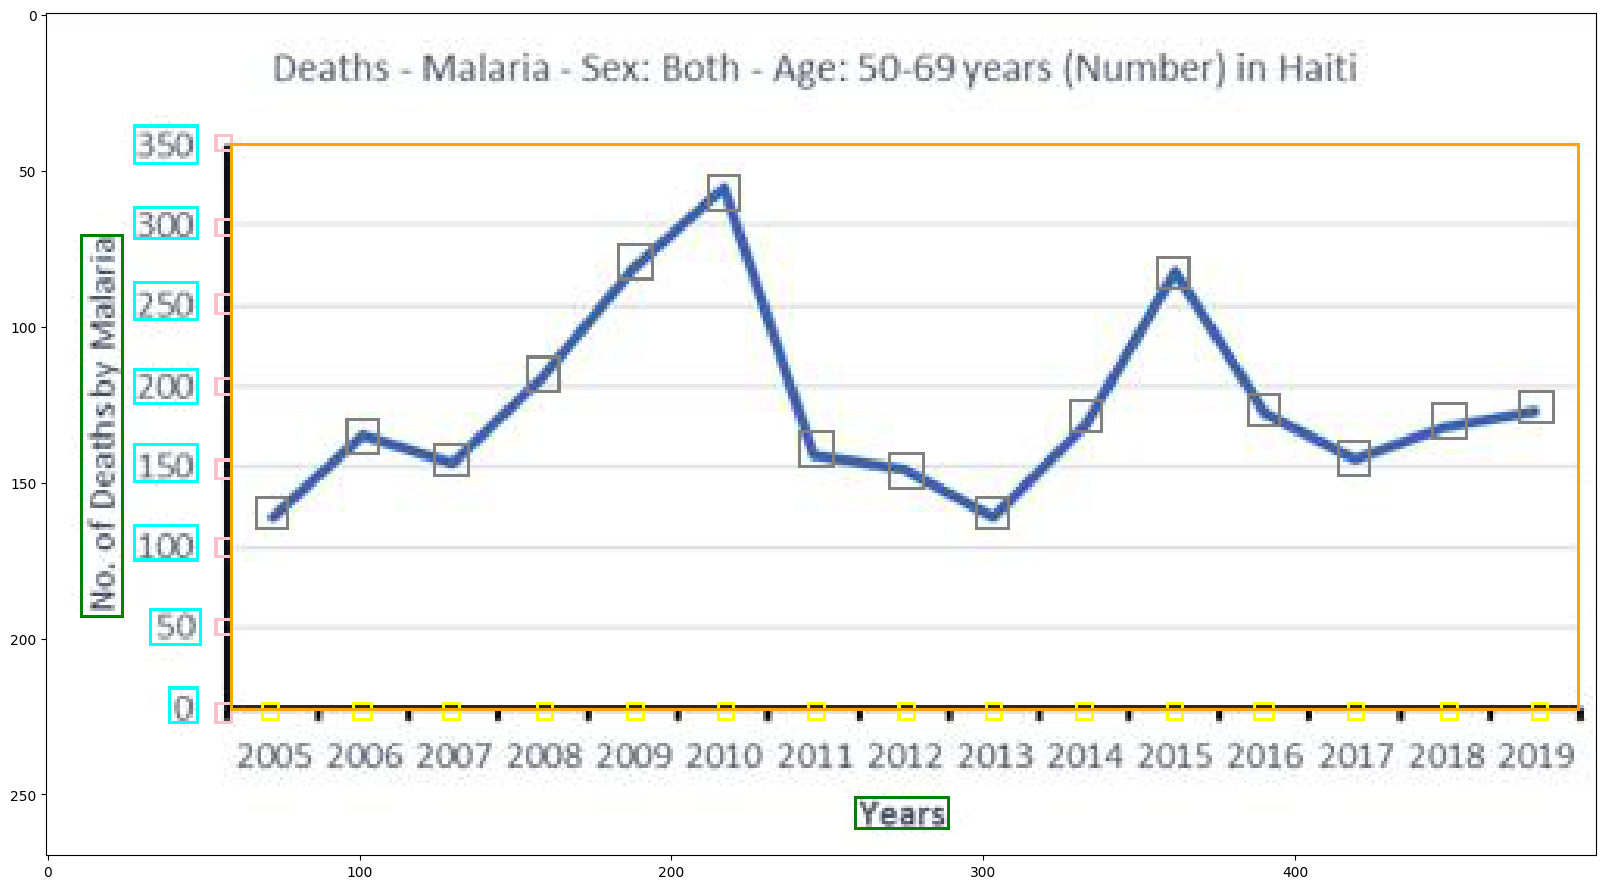

In [32]:
# annotations = '/content/new_annotation/*'
import matplotlib.patches as patches
class_id_to_name_mapping = {v : k for k,v in stoi.items()}
# print(itos)
dict_color = {'chart_title' : 'red',
              'axis_title' : 'green',
              'tick_label' : 'blue',
              'plot-bb' : 'orange',
              'x-axis-tick' : 'yellow',
              'y-axis-tick' : 'pink',
              'visual-point' : 'gray',
              'other' : 'brown',
              'tick_grouping' : 'black',
              'y_tick_label' : 'aqua'}
# fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (20,15)
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    # print(w,h)
    # print(image.size)
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    # print(transformed_annotations)
    # print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        # obj_cls, x0, y0, w, h = int(ann[0]),int(ann[1]),int(ann[2]),int(ann[3]),int(ann[4])
        obj_cls, x0, y0, x1, y1 = ann
        # print(class_id_to_name_mapping[obj_cls])
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline = dict_color[class_id_to_name_mapping[obj_cls]])
        # plotted_image.point((x0,y0),fill='black')
        # print(class_id_to_name_mapping[(int(obj_cls))])
        # if class_id_to_name_mapping[(int(obj_cls))] in ["chart_title", "axis_title", "tick_label"]:
        #   image_patch = np.array(image)[int(y0):int(y1),int(x0):int(x1)]
        #   plt.imshow(image_patch)
        #   print(image_patch.shape)
        #   extracted_text = text_reader.readtext(image_patch)
        #   for (bbox, text, prob) in extracted_text:
        #       print(text)
        #   # print(extracted_text)
        # plt.show()

        # plotted_image.text((x0, y0 + 10), class_id_to_name_mapping[(int(obj_cls))], (128, 255, 128))
        # print( class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice([os.path.join('/content/yolov5/runs/detect/yolo_test_det/labels', x) for x in os.listdir('/content/yolov5/runs/detect/yolo_test_det/labels') if x[-3:] == "txt"])
# annotation_file = '/content/yolov5/runs/detect/yolo_test_det/labels/fc37f02296d6.txt'
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    print(annotation_list)
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# print(annotation_list)
#Get the corresponding image file
# print(annotation_file)
image_file = annotation_file.replace("/content/yolov5/runs/detect/yolo_test_det/labels", "/content/chart2table/images/test").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)